## Multiple Linear Regression via QR Decomposition: House Price Prediction
This notebook implements an efficient and numerically stable approach to multilinear regression to predict **House Prices** based on the following features:
* **Gross Living Area:** `square_meters`
* **Room Count:** `num_rooms`
* **Location:** `loc_score`
* **Age:** `age_years`

**Mathematical Approach:**
We model the relationship as $y = \theta + \alpha x_1 + \beta x_2 + \gamma x_3 + \delta x_4 + \epsilon$.
Our goal is to determine the optimal parameter vector $\mathbf{x} = [\theta, \alpha, \beta, \gamma, \delta]^T$ (intercept and slopes) that minimizes the sum of squared errors $\sum \epsilon^2 = \| \mathbf{b} - \mathbf{A}\mathbf{x} \|^2$.

To ensure computational efficiency and numerical stability, we utilize **QR Decomposition** ($\mathbf{A} = \mathbf{Q}\mathbf{R}$) instead of the standard Normal Equations. Specifically, the Economic QR Decomposition is used, which is vital for huge datasets as it avoids computing the full, memory-intensive orthogonal matrix $\mathbf{Q}$. This transforms the problem into a stable upper-triangular system:

$$
\mathbf{R} \mathbf{x} = \mathbf{Q}^T \mathbf{b}
$$

where $\mathbf{Q}$ is an orthogonal matrix and $\mathbf{R}$ is upper-triangular. We solve for $\mathbf{x}$ via back-substitution and evaluate our model.

### Libraries Import

In [2]:
from scipy.linalg import qr, solve_triangular
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Dataset Generation

In [3]:
# Running generation script
%run house_prices_dataset_linear_generation.py
# Importing via pandas (file in same directory)
df = pd.read_csv("house_prices_dataset_linear.csv")

File 'house_prices_dataset_linear.csv' created successfully!


### Constructing System Matrices $A$ and $b$

In [4]:
# Constructing the Target Vector b
b = df["price"].values[None, :].T

# Constructing the Feature Matrix A
feature_cols = ["square_meters", "num_rooms", "loc_score", "age_years"]
A_features = df[feature_cols].values

# Create the Intercept Column of 1s
intercept_col = np.ones(len(df))[None, :].T

# Horizontally stacking the arrays
A = np.hstack((intercept_col, A_features))

# Checking the dimensions
print(f"Matrix A shape: {A.shape}")
print(f"Vector b shape: {b.shape}")

Matrix A shape: (100, 5)
Vector b shape: (100, 1)


### Solving for Parameter Vector $x$

In [5]:
# Economic QR Decomposition
Q, R = qr(A, mode="economic")

# Calculating the matrix product Q.T * b
Q_T_b = Q.T @ b

# Solving the triangular system R * x = Q.T * b for x
x = solve_triangular(R, Q_T_b)

# Round x to integer
x = np.round(x).astype(int)

# Final Regression Coefficients
parameter_names = [
    "intercept (theta)",
    "square_meters (alpha)",
    "num_rooms (beta)",
    "loc_score (gamma)",
    "age_years (delta)"
]

results_df = pd.DataFrame({
    "Parameter": parameter_names,
    "Value": x.flatten()
})

print("    Regression Coefficients")
print("--------------------------------")
print(results_df.to_string(index=False))

    Regression Coefficients
--------------------------------
            Parameter  Value
    intercept (theta)  40948
square_meters (alpha)   2446
     num_rooms (beta)  19035
    loc_score (gamma)  26555
    age_years (delta)   -787


### Visualizing Residuals vs. Predicted Price

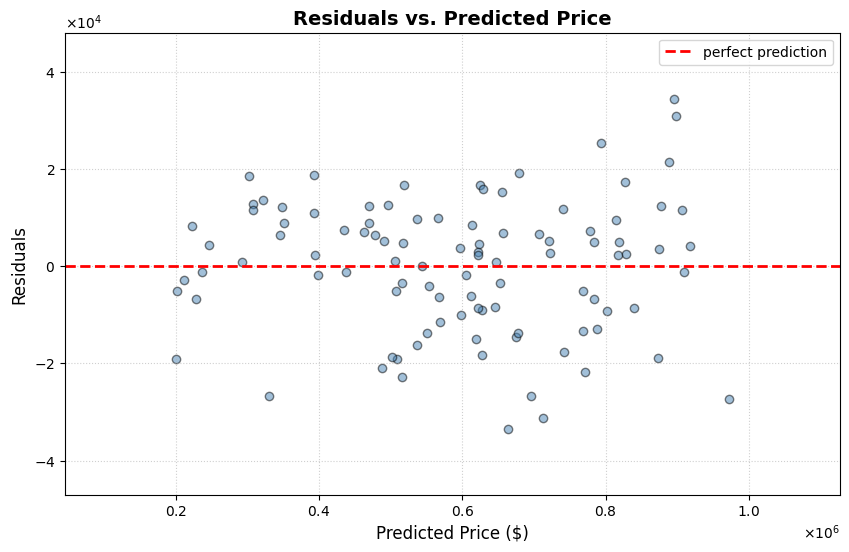

In [6]:
# Calculating Predictions and Residuals
b_pred = A @ x
residuals = b - b_pred

# Plotting Residuals vs Predictions
plt.figure(figsize=(10, 6))

# Scatter plot of residuals
plt.scatter(b_pred, residuals, alpha=0.5, color="steelblue", edgecolor="k")

# Add perfect prediction line
plt.axhline(0, color="red", linestyle="--", linewidth=2, label="perfect prediction")

plt.ticklabel_format(style="sci", axis="both", scilimits=(0, 0), useMathText=True)
plt.margins(0.2)
plt.title("Residuals vs. Predicted Price", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Price ($)", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.show()

### Visualizing Partial Dependency

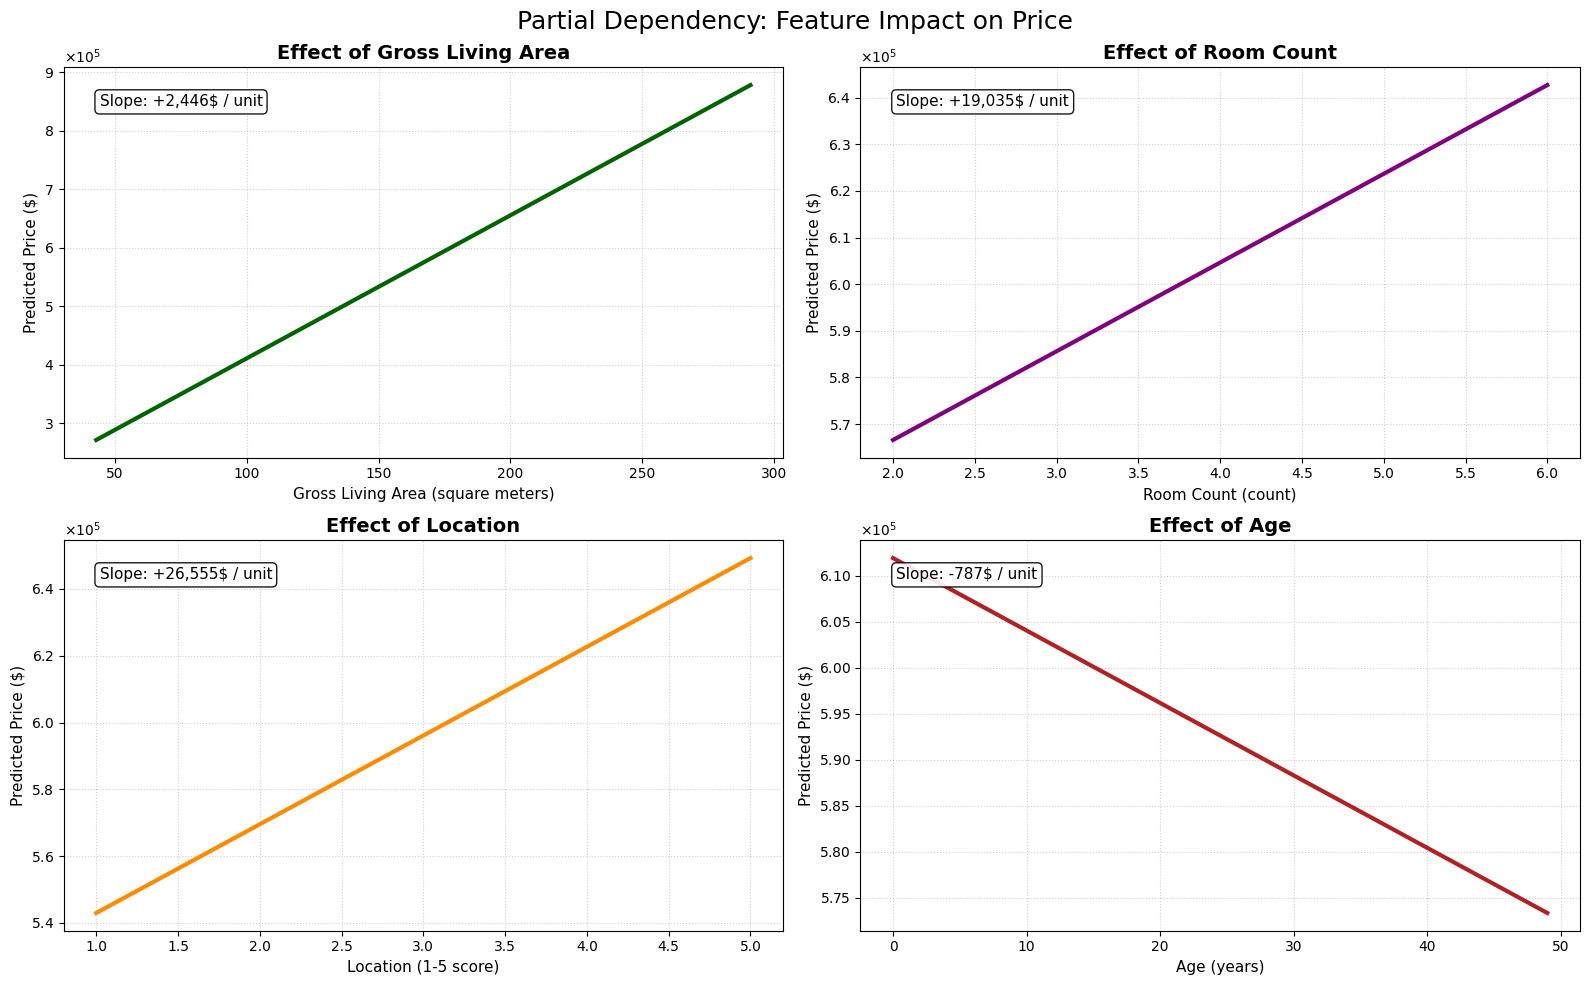

In [7]:
x_flat = x.flatten()
means = np.mean(A, axis=0)

# Features to plot
features_info = [
    {"idx": 1, "name": "Gross Living Area", "unit": "square meters", "color": "darkgreen"},
    {"idx": 2, "name": "Room Count",   "unit": "count",      "color": "purple"},
    {"idx": 3, "name": "Location",    "unit": "1-5 score",  "color": "darkorange"},
    {"idx": 4, "name": "Age",      "unit": "years",      "color": "firebrick"}
]

# Creating subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Looping through each feature
for i, feature in enumerate(features_info):
    ax = axes[i]
    idx = feature["idx"]

    feature_range = np.linspace(A[:, idx].min(), A[:, idx].max(), 100)

    base_effect = 0
    for j in range(len(x_flat)):
        if j != idx:
            base_effect += means[j] * x_flat[j]

    # Calculating partial dependence line
    pdp_y = (feature_range * x_flat[idx]) + base_effect

    # Plotting the line
    ax.plot(feature_range, pdp_y, color=feature["color"], linewidth=3)

    # Formatting
    ax.set_title(f"Effect of {feature["name"]}", fontsize=14, fontweight="bold")
    ax.set_xlabel(f"{feature["name"]} ({feature["unit"]})", fontsize=11)
    ax.set_ylabel("Predicted Price ($)", fontsize=11)
    ax.grid(True, linestyle=":", alpha=0.6)

    # Slope Annotations
    slope = int(x_flat[idx])
    formatted_slope = f"{slope:+,d}"
    ax.text(0.05, 0.90, f"Slope: {formatted_slope}$ / unit",
            transform=ax.transAxes, fontsize=11,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

    ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0), useMathText=True)

plt.suptitle("Partial Dependency: Feature Impact on Price", fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

### Price Prediction

In [8]:
# New feature values for price prediction
new_square_meters = 200
new_num_rooms = 4
new_loc_score = 3
new_age_years = 10

# Constructing input vector
a = np.array([1, new_square_meters, new_num_rooms, new_loc_score, new_age_years])

# Prediction calculation
predicted_price = np.dot(a, x).item()

# Show result
print("--------- Input ---------")
print(f"Gross Living Area: {new_square_meters} m²")
print(f"Room Count: {new_num_rooms}")
print(f"Location Score: {new_loc_score}")
print(f"Age: {new_age_years} years")
print("---------- Prediction ----------")
print(f"The predicted price is: {predicted_price}$")

--------- Input ---------
Gross Living Area: 200 m²
Room Count: 4
Location Score: 3
Age: 10 years
---------- Prediction ----------
The predicted price is: 678083$
